In [1]:
%matplotlib notebook

In [2]:
from meshmaker import vec3, planargraph, triangulation, Loops
from meshmaker.geometry import sintsxyp, orient2d
from meshmaker.plt import *

In [3]:
def missingedges(self):
    unfin = []
    for p, q in self.edges:
        u = self._fp(p, e=self.epsilon)
        v = self._fp(q, e=self.epsilon)
        if self.trianglelookup.get((u, v)) is None:
            unfin.append((u, v))
    return unfin

def recoveredges(self):
    for u, v in missingedges(self):
        # find all edges which intersect missing edge uv
        p, q = self.points[u], self.points[v]
        badedges = []
        for x, y, z in filter(None, self.triangles):
            a, b, c = self.points[x], self.points[y], self.points[z]
            if sintsxyp(p, q, a, b, 0, 0, 0, 1):
                badedges.append((x, y)) 
            elif sintsxyp(p, q, b, c, 0, 0, 0, 1): 
                badedges.append((y, z)) 
            elif sintsxyp(p, q, c, a, 0, 0, 0, 1): 
                badedges.append((z, x))

        # if there are exactly 2, only an edge flip is required (?)
        if len(badedges) == 2:
            self.flipedge(*badedges[0])
            return

        # given a list of edges which intersect the edge uv
        # produce a left and right loop wrt edge uv
        p, q = self.points[u], self.points[v]
        T = (q - p)
        left, right = set([v]), set([u])
        for x, y in badedges:
            z = self.adjacent(x, y)
            a, b, c = self.points[x], self.points[y], self.points[z]
            (left if (orient2d(p, q, a) > 0) else right).add(x)    
            (left if (orient2d(p, q, b) > 0) else right).add(y)    
            (left if (orient2d(p, q, c) > 0) else right).add(z)

        # make sure each list ends with how the other began
        if not u in left:
            left.add(u)
        if not v in right:
            right.add(v)

        # sort points along tangent of UV to retriangulate with fan
        # should sort by angle from edge UV instead?
        sort = lambda r: (self.points[r].dot(T) - p.dot(T))
        left = sorted(left, key=sort, reverse=False)
        right = sorted(right, key=sort, reverse=False)

        #print('-' * 50)
        #print(u, v)
        #print(left)
        #print(right)
        #print('-' * 50)

        # delete the triangles associated with the bad edges
        for x, y in badedges:
            z = self.adjacent(x, y)
            self.deletetriangle(x, y, z)

        # add the triangles from a fan of left and right loops
        for i in range(2, len(left)):
            self.addtriangle(left[0], left[i - 1], left[i])
        for i in range(2, len(right)):
            self.addtriangle(right[0], right[i - 1], right[i])        
        
        f, ax = plot()
        self.plot(ax)
        plot_loop(ax, [self.points[m] for m in left], col='c')
        plot_loop(ax, [self.points[m] for m in right], col='m')


def triangulate(self):
    pys = [(l, []) for l in self.loops]
    for h in self.holes:
        p = self._findparent(h, mode='not-strict')
        pys[p][1].append(h)
    tris = [triangulation(py, 0.0001, hmin=None, constrain=recoveredges) for py in pys]
    tris = [t for tri in tris for t in tri.simplices()]
    return tris


clip self to hole
clip self to hole
clip self to hole


<IPython.core.display.Javascript object>


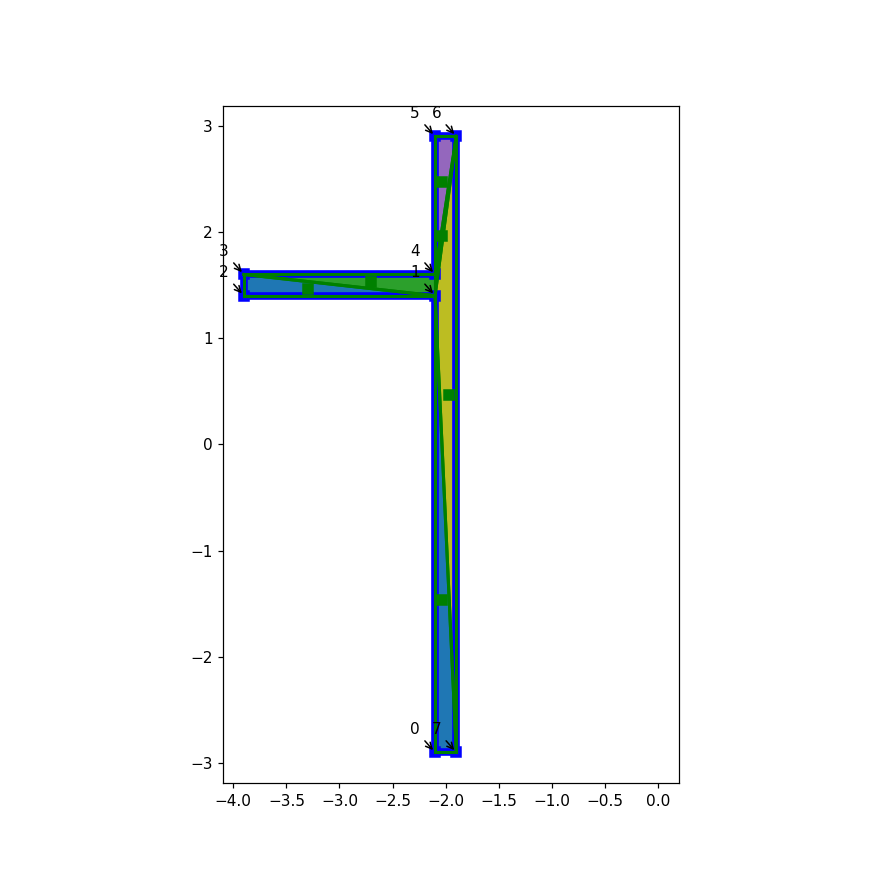

In [4]:
py = ([[vec3(-0.1000, 2.9000, 1.6000), vec3(-3.9000, 2.9000, 1.6000), vec3(-3.9000, -2.9000, 1.6000), vec3(-0.1000, -2.9000, 1.6000)], [[vec3(-1.9000, -2.9000, 1.6000), vec3(-0.1000, -2.9000, 1.6000), vec3(-0.1000, 2.9000, 1.6000), vec3(-1.9000, 2.9000, 1.6000)], [vec3(-3.9000, 1.6000, 1.6000), vec3(-2.1000, 1.6000, 1.6000), vec3(-2.1000, 2.9000, 1.6000), vec3(-3.9000, 2.9000, 1.6000)], [vec3(-3.9000, 1.4000, 1.6000), vec3(-3.9000, -2.9000, 1.6000), vec3(-2.1000, -2.9000, 1.6000), vec3(-2.1000, 1.4000, 1.6000)]]])

lp = Loops([py[0]])#.offset(-0.1)
for h in py[1]:
    lp.embed(h, mode='clip')
    #lp.ah(h)

#t = triangulation(py, 0.0001, hmin=None)

f, ax = plot()
ax.set_aspect(1)
lp.plot(ax, col='b', lw=5, mk='s')
#t.plot(ax)
for l in triangulate(lp):
    if all(((p.d(vec3.O()) < 10) for p in l)):
        plot_loop(ax, list(l), col='g', lw=2, fill=0.2)
        plot_point(ax, vec3.com(list(l)), col='g', mk='s')